In [1]:
"""
Open and display some cementum CT scan images

"""

import pathlib
import matplotlib.pyplot as plt

# This is just where the raw CT scan images are for me
data_dir = pathlib.Path("../cementum/data/original cut")

indices = tuple(range(108, 216))
images = [plt.imread(data_dir / f"{idx:04d}.tif") for idx in indices]

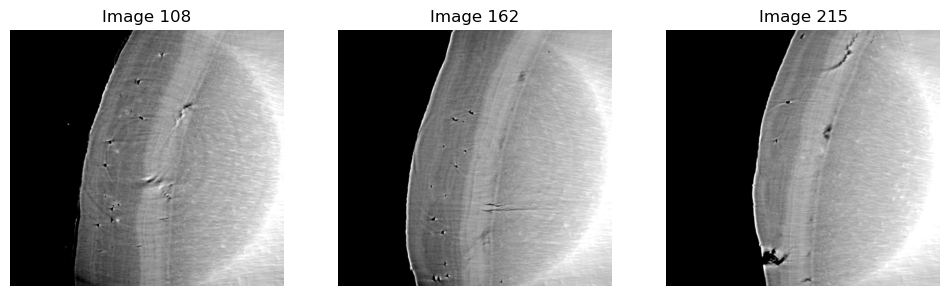

In [2]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, image, idx in zip(
    axes,
    [images[0], images[len(images) // 2], images[-1]],
    [indices[0], indices[len(indices) // 2], indices[-1]],
):
    ax.imshow(image, cmap="gray")
    ax.set_title(f"Image {idx}")
    ax.set_axis_off()

In [3]:
"""
Crop them to remove much of the background and dentin

"""

left, right = 50, 550
cropped_images = [image[:, left:right] for image in images]

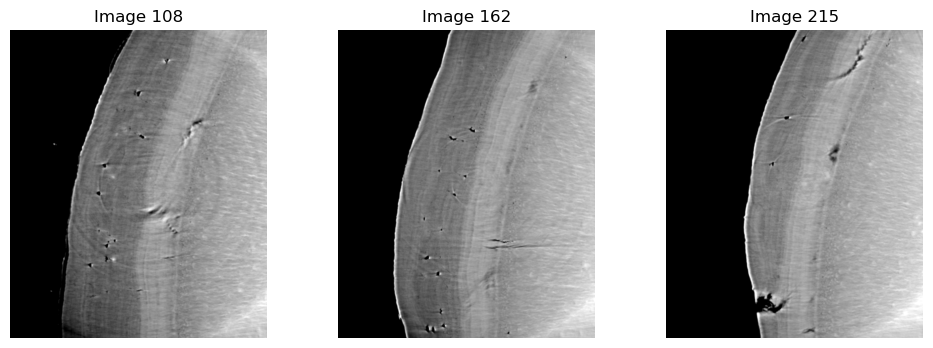

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, image, idx in zip(
    axes,
    [cropped_images[0], cropped_images[len(cropped_images) // 2], cropped_images[-1]],
    [indices[0], indices[len(indices) // 2], indices[-1]],
):
    ax.imshow(image, cmap="gray")
    ax.set_title(f"Image {idx}")
    ax.set_axis_off()

In [5]:
"""
Normalise the stack of images to have a standard mean and standard deviation

"""

import numpy as np

stack = np.stack(cropped_images, axis=0)
stack.shape

(108, 600, 500)

In [6]:
def normalise_stack(stack):
    return (stack - stack.mean()) / stack.std()

In [7]:
normalised_stack = normalise_stack(stack)

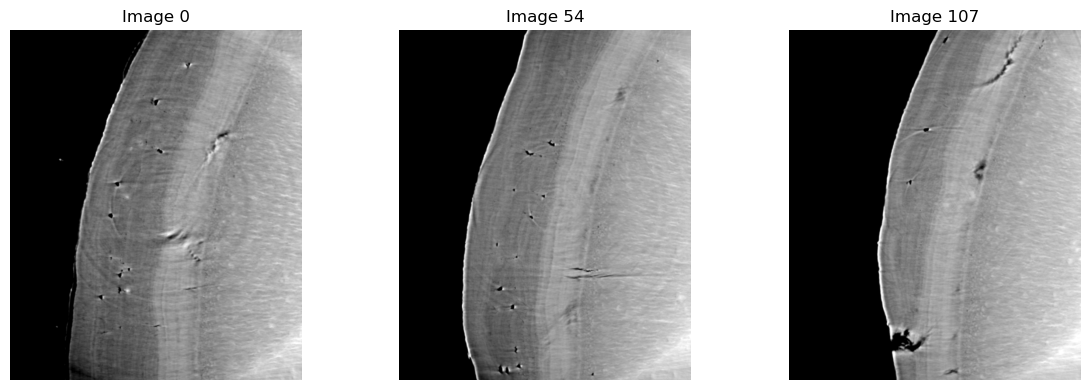

In [8]:
def plot_stack(stack):
    indices = [0, len(stack) // 2, len(stack) - 1]
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for ax, idx in zip(axes, indices):
        ax.imshow(stack[idx], cmap="gray")
        ax.set_title(f"Image {idx}")
        ax.set_axis_off()

    fig.tight_layout()


plot_stack(normalised_stack)

In [9]:
"""
Find the 2d ridge orientation of one of these images

"""

import warnings

import cv2
from scipy import signal, ndimage


def gaussfilter_2d(sze, gradient_sigma):
    sze = np.fix(6 * gradient_sigma)

    # Ensure it is odd in size
    if np.remainder(sze, 2) == 0:
        warnings.warn("The filter size is even, adding 1")
        sze = sze + 1

    gauss = cv2.getGaussianKernel(int(sze), gradient_sigma)
    return gauss * gauss.T


def smooth_covariance_data(grad_x2, grad_y2, grad_xy, block_sigma):
    sze = np.fix(6 * block_sigma)

    gauss = cv2.getGaussianKernel(int(sze), block_sigma)
    filter_gauss = gauss * gauss.T

    return (
        ndimage.convolve(grad_x2, filter_gauss),
        ndimage.convolve(grad_y2, filter_gauss),
        ndimage.convolve(grad_xy, filter_gauss),
    )


def principal_orientation(grad_x2, grad_y2, grad_xy):
    denom = np.sqrt(grad_xy**2 + (grad_x2 - grad_y2) ** 2) + np.finfo(float).eps

    sin_2theta = grad_xy / denom
    cos_2theta = (grad_x2 - grad_y2) / denom

    return sin_2theta, cos_2theta


def smooth_orientation(sin_2theta, cos_2theta, smooth_sigma):
    sze = np.fix(6 * smooth_sigma)

    if np.remainder(sze, 2) == 0:
        warnings.warn("The filter size is even, adding 1")
        sze = sze + 1

    gauss = cv2.getGaussianKernel(int(sze), smooth_sigma)
    filter_gauss = gauss * gauss.T

    sin_2theta = ndimage.convolve(sin_2theta, filter_gauss)
    cos_2theta = ndimage.convolve(cos_2theta, filter_gauss)

    return sin_2theta, cos_2theta


def find_2d_orientation(
    image, sze, gradient_sigma, block_sigma, smooth_sigma: float = None
):
    """
    Estimate local orientation of ridges in an image

    """
    # Create a 2D Gaussian filter
    filter_gauss = gaussfilter_2d(sze, gradient_sigma)

    # Calculate the gradient of the filter
    filter_grad_y, filter_grad_x = np.gradient(filter_gauss)

    # Convolve the image with the gradient filters
    gradient_x = signal.convolve2d(image, filter_grad_x, mode="same")
    gradient_y = signal.convolve2d(image, filter_grad_y, mode="same")

    # Find the covariance data of the gradients
    grad_x2 = gradient_x**2
    grad_y2 = gradient_y**2
    grad_xy = gradient_x * gradient_y

    # Smooth the covariance data
    grad_x2, grad_y2, grad_xy = smooth_covariance_data(
        grad_x2, grad_y2, grad_xy, block_sigma
    )

    # Find an analytic solution to the principal direction
    sin_2theta, cos_2theta = principal_orientation(grad_x2, grad_y2, grad_xy)

    # Smooth the principal direction field
    if smooth_sigma is not None:
        sin_2theta, cos_2theta = smooth_orientation(
            sin_2theta, cos_2theta, smooth_sigma
        )

    return np.pi / 2 + np.arctan2(sin_2theta, cos_2theta) / 2

/tmp/ipykernel_3360/4246314439.py:17: UserWarning: The filter size is even, adding 1
  warnings.warn("The filter size is even, adding 1")
/tmp/ipykernel_3360/4246314439.py:50: UserWarning: The filter size is even, adding 1
  warnings.warn("The filter size is even, adding 1")


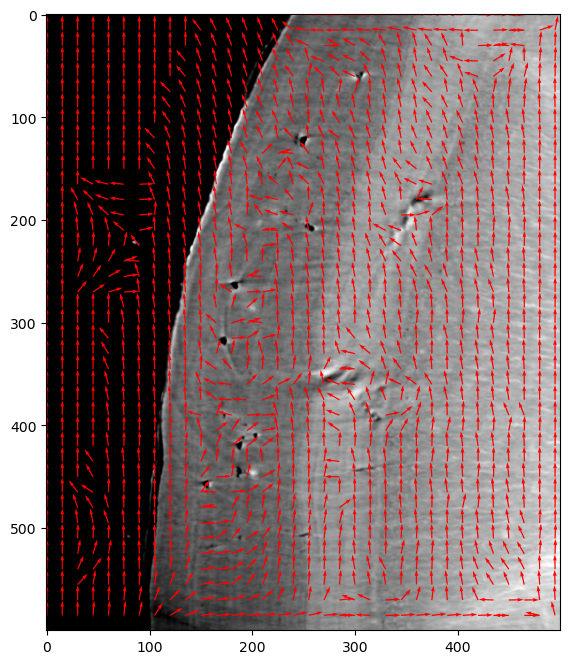

In [10]:
image = stack[0]

orientations = find_2d_orientation(image, 16, 11, 6, 1)

U = np.cos(orientations)
V = np.sin(orientations)
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))


fig, axis = plt.subplots(figsize=(8, 8))
axis.imshow(image, cmap="gray")

step_size = 15
axis.quiver(
    X[::step_size, ::step_size],
    Y[::step_size, ::step_size],
    U[::step_size, ::step_size],
    V[::step_size, ::step_size],
    color="r",
    scale=35,
)

fig.savefig("tmp.png")

In [11]:
"""
Find the 2d ridge frequency from one of these images

"""

'\nFind the 2d ridge frequency from one of these images\n\n'

In [12]:
"""
Apply Gabor filters to this image in 2d

"""

'\nApply Gabor filters to this image in 2d\n\n'

In [13]:
"""
Find the 3d ridge orientation for the stack of images

"""

'\nFind the 3d ridge orientation for the stack of images\n\n'

In [14]:
"""
Find the 3d ridge frequency for the stack of images

"""

'\nFind the 3d ridge frequency for the stack of images\n\n'

In [15]:
"""
Apply Gabor filters in 3d

"""

'\nApply Gabor filters in 3d\n\n'